In [1]:
import sys, os
from fractions import Fraction
import pandas as pd
import seaborn as sns
from ms3 import transform, name2fifths, fifths2pc
sys.path.append(os.path.abspath('../python_scripts/'))
from data_types import ChordType, PitchType
from constants import TRIAD_REDUCTION

def vc(S):
    """Value counts & normalized column"""
    vc = S.value_counts(dropna=False)
    return pd.concat([vc, vc / vc.sum()], axis=1, keys=['counts', 'fraction'])

In [2]:
data = '../Data/Beethoven_sonata_progression/'
csv_files = os.listdir(data)
fnames = [os.path.splitext(f)[0] for f in csv_files]
csv_paths = [os.path.join(data, f) for f in csv_files]
dtypes = dict(binary=bool, vl=int)
to_frac = lambda f: Fraction(f).limit_denominator(8)
converters = dict(tbt=to_frac)
D = pd.concat([pd.read_csv(p, dtype=dtypes, converters=converters) for p in csv_paths], keys=fnames).sort_index()
D.head()

time annotation1_chord annotation2_chord  sps  vl tbt  binary
01-1 0  0.00      F_MINOR_inv0      F_MINOR_inv0  0.0   0   0   False
     1  0.25      F_MINOR_inv0      F_MINOR_inv0  0.0   0   0   False
     2  0.50      F_MINOR_inv0      F_MINOR_inv0  0.0   0   0   False
     3  0.75      F_MINOR_inv0      F_MINOR_inv0  0.0   0   0   False
     4  1.00      F_MINOR_inv0      F_MINOR_inv0  0.0   0   0   False

**Percentage of diverging labels** (binary=True)

In [3]:
vc(D.binary)

,counts,fraction
False,22798,0.666784
True,11393,0.333216


### Durations or counts?
Set `delete_repetitions` to False to have the notebook account for the durations of divergences.

Set it to True if you only care about their counts. In this case you will see the new proportion between identical and diverging labels.

In [4]:
delete_repetitions = True

if delete_repetitions:
    changed1 = D.annotation1_chord != D.annotation1_chord.shift()
    changed2 = D.annotation2_chord != D.annotation2_chord.shift()
    D = D[changed1 | changed2]
    print(D.binary.value_counts(normalize=True))

False    0.558847
True     0.441153
Name: binary, dtype: float64


In [5]:
df = D[D.binary] # select only diverging

**Overview Spectral Pitch distances**

count    3321.000000
mean        0.278306
std         0.262536
min         0.000000
25%         0.068873
50%         0.163216
75%         0.454415
max         0.960042
Name: sps, dtype: float64


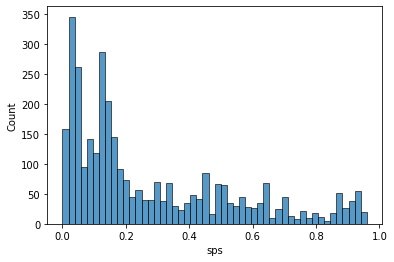

In [6]:
print(df.sps.describe())
sns.histplot(data=df, x='sps', bins=50);

**Overview Voice Leading distances**

count    3321.000000
mean        9.128877
std         5.975574
min         0.000000
25%         3.000000
50%         9.000000
75%        14.000000
max        24.000000
Name: vl, dtype: float64


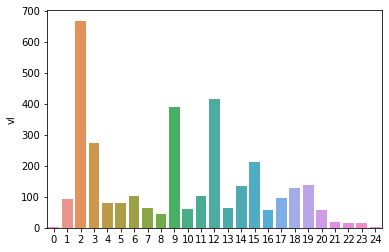

In [7]:
print(df.vl.describe())
vl = df.vl.value_counts()
sns.barplot(x=vl.index, y=vl);

**Overview tone-by-tone distances**

count    3321.000000
mean        0.498726
std         0.283832
min         0.125000
25%         0.285714
50%         0.428571
75%         0.750000
max         1.000000
Name: tbt, dtype: float64


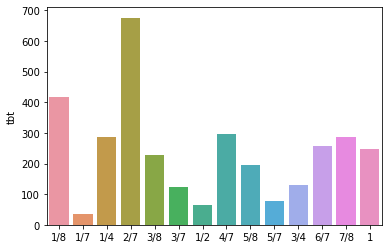

In [8]:
print(df.tbt.astype(float).describe())
tbt = df.tbt.value_counts()
sns.barplot(x=tbt.index, y=tbt);

## Expanding the data to inspect different categories of chord divergence

In [9]:
regex = r"^([A-G](b*|#*)?)_(.*)_inv(\d)$"
def is_triad(type_str):
    val = ChordType[type_str]
    return val.value < 4
df = D[D.binary]
for n, col in ((1, 'annotation1_chord'), (2, 'annotation2_chord')):
    renaming = {0: f"root{n}", 2: f"type{n}", 3: f"inv{n}", 'triad': f"triad{n}", 'tpc': f"tpc{n}", 'pc': f"pc{n}"}
    expanded = df[col].str.extract(regex).loc[:, [0, 2, 3]]
    expanded['triad'] = transform(expanded[2], is_triad)
    expanded['tpc'] = transform(expanded[0], name2fifths)
    expanded['pc'] = transform(expanded.tpc, fifths2pc)
    df = pd.concat([df, expanded.rename(columns=renaming)], axis=1)
df = pd.concat([df,
                (df.tpc1-df.tpc2).abs().rename('tpc_iv'), 
                (df.pc1 - df.pc2).abs().rename('pc_iv')], axis=1)
df.pc_iv = df.pc_iv.where(df.pc_iv <= 6, 12 - df.pc_iv)
df.head()

time  annotation1_chord annotation2_chord       sps  vl  tbt  \
01-1 30   5.25  E_DIMINISHED_inv1   C_MAJ_MIN7_inv2  0.049170   2  3/8   
     43   7.25       C_MAJOR_inv0   C_MAJ_MIN7_inv0  0.006025   2  1/8   
     56  10.25   Db_MAJ_MAJ7_inv3  Db_MAJ_MAJ7_inv1  0.075546  15  1/4   
     87  16.00      Ab_MAJOR_inv1     Eb_MAJOR_inv0  0.447499  12  6/7   
     95  18.00      Ab_MAJOR_inv1     Eb_MAJOR_inv0  0.447499  12  6/7   

         binary root1       type1 inv1  ...  tpc1  pc1  root2     type2 inv2  \
01-1 30    True     E  DIMINISHED    1  ...     4    4      C  MAJ_MIN7    2   
     43    True     C       MAJOR    0  ...     0    0      C  MAJ_MIN7    0   
     56    True    Db    MAJ_MAJ7    3  ...    -5    1     Db  MAJ_MAJ7    1   
     87    True    Ab       MAJOR    1  ...    -4    8     Eb     MAJOR    0   
     95    True    Ab       MAJOR    1  ...    -4    8     Eb     MAJOR    0   

        triad2  tpc2  pc2  tpc_iv  pc_iv  
01-1 30  False     0    0       4      4  
     43  False     0    0       0      0  
     56  False    -5    1       0      0  
     87   True    -3    3       1      5  
     95   True    -3    3       1      5  

[5 rows x 21 columns]

In [10]:
same_root = df.tpc_iv == 0
same_type = df.type1 == df.type2
same_inversion = df.inv1 == df.inv2

### Inspecting chords diverging only by inversion
**Proportion of diverging chords that have the same root and type but different inversion (True)**

In [11]:
diverging_inv = same_root & same_type
vc(diverging_inv)

,counts,fraction
False,2377,0.715748
True,944,0.284252


In [12]:
inv_groups = df.loc[diverging_inv, ['inv1', 'inv2']]\
                 .apply(lambda row: tuple(sorted(row.astype(int))), axis=1)\
                 .rename('inversions')
inv_dist = inv_groups.map(lambda t: abs(t[0] - t[1])).rename('inv_dist')
different_inversions = pd.concat([df[diverging_inv], inv_groups, inv_dist], axis=1)
vc(different_inversions.inv_dist)

,counts,fraction
1,669,0.708686
2,233,0.246822
3,42,0.044492


In [13]:
different_inversions.groupby(['inv_dist', 'triad1', 'inversions']).size()

inv_dist  triad1  inversions
1         False   (0, 1)         50
                  (1, 2)         42
                  (2, 3)         59
          True    (0, 1)        441
                  (1, 2)         77
2         False   (0, 2)         42
                  (1, 3)         33
          True    (0, 2)        158
3         False   (0, 3)         42
dtype: int64

#### Tone by tone

In [14]:
vc(different_inversions.tbt)

,counts,fraction
2/7,676,0.716102
1/4,268,0.283898


In [15]:
different_inversions.groupby(['tbt', 'triad1', 'inversions']).size()

tbt  triad1  inversions
1/4  False   (0, 1)         50
             (0, 2)         42
             (0, 3)         42
             (1, 2)         42
             (1, 3)         33
             (2, 3)         59
2/7  True    (0, 1)        441
             (0, 2)        158
             (1, 2)         77
dtype: int64

**Grouping `tbt` values by combinations of inversions shows that all tetrads have the distance `1/4` and all triads the distance `2/7`** Note that the chords in question all share the same root.

#### Voice leading

In [16]:
vc(different_inversions.vl)

,counts,fraction
12,345,0.365466
9,332,0.351695
15,193,0.204449
18,40,0.042373
6,34,0.036017


In [17]:
different_inversions.groupby(['vl', 'inv_dist', 'triad1']).size()

vl  inv_dist  triad1
6   3         False      34
9   1         False     107
              True      217
    3         False       8
12  1         False      44
              True      301
15  2         False      40
              True      153
18  2         False      35
              True        5
dtype: int64

In [18]:
different_inversions.groupby(['inv_dist', 'triad1', 'type1', 'inversions', 'vl']).size()

inv_dist  triad1  type1       inversions  vl
1         False   DIM7        (0, 1)      9       3
                              (1, 2)      9       6
                              (2, 3)      9      10
                  HALF_DIM7   (1, 2)      9       2
                  MAJ_MIN7    (0, 1)      12     44
                              (1, 2)      9      34
                              (2, 3)      9      49
                  MIN_MIN7    (0, 1)      9       3
          True    DIMINISHED  (0, 1)      9      21
                              (1, 2)      9       2
                  MAJOR       (0, 1)      12    275
                              (1, 2)      9      49
                  MINOR       (0, 1)      9     145
                              (1, 2)      12     26
2         False   DIM7        (0, 2)      18      2
                              (1, 3)      18     16
                  HALF_DIM7   (0, 2)      18      1
                  MAJ_MAJ7    (1, 3)      15      1
                  M

In [19]:
different_inversions.groupby(['vl', 'type1', 'inversions']).size()

vl  type1       inversions
6   MAJ_MIN7    (0, 3)         34
9   DIM7        (0, 1)          3
                (0, 3)          8
                (1, 2)          6
                (2, 3)         10
    DIMINISHED  (0, 1)         21
                (1, 2)          2
    HALF_DIM7   (1, 2)          2
    MAJOR       (1, 2)         49
    MAJ_MIN7    (1, 2)         34
                (2, 3)         49
    MINOR       (0, 1)        145
    MIN_MIN7    (0, 1)          3
12  MAJOR       (0, 1)        275
    MAJ_MIN7    (0, 1)         44
    MINOR       (1, 2)         26
15  MAJOR       (0, 2)         82
    MAJ_MAJ7    (1, 3)          1
    MAJ_MIN7    (0, 2)         39
    MINOR       (0, 2)         71
18  DIM7        (0, 2)          2
                (1, 3)         16
    DIMINISHED  (0, 2)          5
    HALF_DIM7   (0, 2)          1
    MAJ_MIN7    (1, 3)         16
dtype: int64

**`18` is among the highest values that the voice leading distance yiels, so it is rather surprising that chords with the same root and type shall get this value**

#### SPS

In [20]:
different_inversions.groupby(['type1', 'inversions', 'sps']).size().head(60)

type1       inversions  sps     
DIM7        (0, 1)      0.091002     1
                        0.130723     2
            (0, 2)      0.076837     1
                        0.118461     1
            (0, 3)      0.057999     1
                        0.118810     6
                        0.124679     1
            (1, 2)      0.019882     1
                        0.029056     1
                        0.091002     1
                        0.114036     3
            (1, 3)      0.076837     1
                        0.147762    12
                        0.162639     1
                        0.170808     2
            (2, 3)      0.057999     1
                        0.111540     6
                        0.130723     1
                        0.140453     2
DIMINISHED  (0, 1)      0.024659     6
                        0.026499     2
                        0.036015     1
                        0.085481     2
                        0.130883     2
                        0.13350

**Surprising to see such different distances for transpositionally identical chord combinations**
As an example, let's inspect all cases where both datasets have a diminished 7th chord on the same root, one in first, one in second inversion:

In [21]:
different_inversions[(different_inversions.type1 == 'DIM7') & (different_inversions.inversions == ('1', '2'))]

,,time,annotation1_chord,annotation2_chord,sps,vl,tbt,binary,root1,type1,inv1,...,root2,type2,inv2,triad2,tpc2,pc2,tpc_iv,pc_iv,inversions,inv_dist


In [22]:
gb = different_inversions.groupby('triad1').sps
pd.concat([gb.min(), gb.max()], axis=1, keys=['min_sps', 'max_sps'])

,min_sps,max_sps
triad1,,
False,0.014908,0.176841
True,0.021957,0.180520


### Inspecting chords diverging only by type
**Proportion of diverging chords that have the same root and inversion but different type (True)**

In [23]:
diverging_type = same_root & same_inversion
vc(diverging_type)

,counts,fraction
False,2821,0.849443
True,500,0.150557


#### Tone by tone

In [24]:
type_groups = df.loc[diverging_type, ['type1', 'type2']]\
                 .apply(lambda row: tuple(sorted(row)), axis=1)\
                 .rename('types')
triad_groups = df.loc[diverging_type, ['triad1', 'triad2']]\
                 .apply(lambda row: tuple(sorted(row)), axis=1)\
                 .rename('triads')
different_types = pd.concat([df[diverging_type], type_groups, triad_groups], axis=1)
vc(different_types.tbt)

,counts,fraction
1/8,416,0.832
1/7,35,0.070
1/4,14,0.028
3/7,10,0.020
3/8,10,0.020
5/8,8,0.016
4/7,4,0.008
1/2,3,0.006


In [25]:
different_types.groupby(['tbt', 'triads', 'inv1']).size()

tbt  triads          inv1
1/8  (False, False)  1         2
                     2         5
                     3         2
     (False, True)   0       275
                     1       100
                     2        32
1/7  (True, True)    0        20
                     1         7
                     2         8
1/4  (False, True)   0        14
3/8  (False, False)  1         9
     (False, True)   0         1
3/7  (True, True)    1         4
                     2         6
1/2  (False, False)  1         2
     (False, True)   1         1
4/7  (True, True)    1         4
5/8  (False, True)   1         8
dtype: int64

In [26]:
different_types.groupby(['tbt', 'inv1', 'types']).size()

tbt  inv1  types                  
1/8  0     (DIM7, DIMINISHED)           7
           (DIMINISHED, HALF_DIM7)      7
           (MAJOR, MAJ_MAJ7)            4
           (MAJOR, MAJ_MIN7)          247
           (MINOR, MIN_MIN7)           10
     1     (DIM7, DIMINISHED)           9
           (DIM7, HALF_DIM7)            2
           (DIMINISHED, HALF_DIM7)      6
           (MAJOR, MAJ_MAJ7)            4
           (MAJOR, MAJ_MIN7)           78
           (MINOR, MIN_MIN7)            3
     2     (DIM7, DIMINISHED)           4
           (DIM7, HALF_DIM7)            4
           (MAJOR, MAJ_MIN7)           26
           (MAJ_MIN7, MIN_MIN7)         1
           (MINOR, MIN_MIN7)            2
     3     (HALF_DIM7, MIN_MIN7)        2
1/7  0     (DIMINISHED, MINOR)          1
           (MAJOR, MINOR)              19
     1     (AUGMENTED, MAJOR)           4
           (DIMINISHED, MINOR)          3
     2     (MAJOR, MINOR)               8
1/4  0     (MAJ_MIN7, MINOR)           14

In [27]:
vc(different_types.vl)

,counts,fraction
2,379,0.758
3,53,0.106
1,52,0.104
6,8,0.016
4,7,0.014
5,1,0.002


In [28]:
different_types.groupby(['vl', 'triads', 'types']).size()

vl  triads          types                  
1   (False, False)  (DIM7, HALF_DIM7)            6
                    (HALF_DIM7, MIN_MIN7)        2
                    (MAJ_MIN7, MIN_MIN7)         1
    (False, True)   (MAJOR, MAJ_MAJ7)            8
    (True, True)    (AUGMENTED, MAJOR)           4
                    (DIMINISHED, MINOR)          4
                    (MAJOR, MINOR)              27
2   (False, True)   (DIMINISHED, HALF_DIM7)     13
                    (MAJOR, MAJ_MIN7)          351
                    (MINOR, MIN_MIN7)           15
3   (False, False)  (MAJ_MIN7, MIN_MIN7)         9
    (False, True)   (DIM7, DIMINISHED)          20
                    (MAJ_MIN7, MINOR)           14
    (True, True)    (AUGMENTED, MAJOR)           6
                    (MAJOR, MINOR)               4
4   (False, False)  (HALF_DIM7, MAJ_MIN7)        2
    (False, True)   (DIM7, MAJOR)                1
    (True, True)    (DIMINISHED, MAJOR)          4
5   (False, True)   (MAJ_MIN7, MINOR) 

#### SPS

In [29]:
different_types.sps.describe()

count    500.000000
mean       0.067618
std        0.099480
min        0.003718
25%        0.011275
50%        0.034780
75%        0.055684
max        0.528248
Name: sps, dtype: float64

In [30]:
different_types[different_types.sps > 0.4]

time  annotation1_chord annotation2_chord       sps  vl  tbt  \
08-1 248    16.50000      Gb_MAJOR_inv1      Gb_DIM7_inv1  0.490751   6  5/8   
     312    24.50000      Gb_MAJOR_inv1      Gb_DIM7_inv1  0.490751   6  5/8   
     344    29.50000      Gb_MAJOR_inv1      Gb_DIM7_inv1  0.490751   6  5/8   
     368    33.50000      Gb_MAJOR_inv1      Gb_DIM7_inv1  0.490751   6  5/8   
     1533  200.50000      Gb_MAJOR_inv1      Gb_DIM7_inv1  0.490751   6  5/8   
26-1 85      8.87500  G_DIMINISHED_inv1   G_MAJ_MIN7_inv1  0.527771   6  5/8   
     88      9.37500  F_DIMINISHED_inv1      F_MAJOR_inv1  0.520371   4  4/7   
     611   101.87500  G_DIMINISHED_inv1   G_MAJ_MIN7_inv1  0.527771   6  5/8   
     614   102.37500  F_DIMINISHED_inv1      F_MAJOR_inv1  0.520371   4  4/7   
32-1 48      7.00000        A_DIM7_inv0      A_MAJOR_inv0  0.528248   4  3/8   
     358    33.28125      Gb_MAJOR_inv1      Gb_DIM7_inv1  0.490751   6  5/8   

           binary root1       type1 inv1  ...  root2     type2  inv2 triad2  \
08-1 248     True    Gb       MAJOR    1  ...     Gb      DIM7     1  False   
     312     True    Gb       MAJOR    1  ...     Gb      DIM7     1  False   
     344     True    Gb       MAJOR    1  ...     Gb      DIM7     1  False   
     368     True    Gb       MAJOR    1  ...     Gb      DIM7     1  False   
     1533    True    Gb       MAJOR    1  ...     Gb      DIM7     1  False   
26-1 85      True     G  DIMINISHED    1  ...      G  MAJ_MIN7     1  False   
     88      True     F  DIMINISHED    1  ...      F     MAJOR     1   True   
     611     True     G  DIMINISHED    1  ...      G  MAJ_MIN7     1  False   
     614     True     F  DIMINISHED    1  ...      F     MAJOR     1   True   
32-1 48      True     A        DIM7    0  ...      A     MAJOR     0   True   
     358     True    Gb       MAJOR    1  ...     Gb      DIM7     1  False   

          tpc2 pc2  tpc_iv  pc_iv                   types         triads  
08-1 248    -6   6       0      0           (DIM7, MAJOR)  (False, True)  
     312    -6   6       0      0           (DIM7, MAJOR)  (False, True)  
     344    -6   6       0      0           (DIM7, MAJOR)  (False, True)  
     368    -6   6       0      0           (DIM7, MAJOR)  (False, True)  
     1533   -6   6       0      0           (DIM7, MAJOR)  (False, True)  
26-1 85      1   7       0      0  (DIMINISHED, MAJ_MIN7)  (False, True)  
     88     -1   5       0      0     (DIMINISHED, MAJOR)   (True, True)  
     611     1   7       0      0  (DIMINISHED, MAJ_MIN7)  (False, True)  
     614    -1   5       0      0     (DIMINISHED, MAJOR)   (True, True)  
32-1 48      3   9       0      0           (DIM7, MAJOR)  (False, True)  
     358    -6   6       0      0           (DIM7, MAJOR)  (False, True)  

[11 rows x 23 columns]

### Filtering out tetrad-triad correspondence (e.g. M <-> Mm7)

In [31]:
def reduce_tetrad(type_str):
    val = ChordType[type_str]
    return TRIAD_REDUCTION[val]

same_type_reduced = transform(df.type1, reduce_tetrad) == transform(df.type2, reduce_tetrad)

In [32]:
diverging_type_reduced = diverging_type & ~same_type_reduced
vc(diverging_type_reduced)

,counts,fraction
False,3234,0.973803
True,87,0.026197


In [33]:
different_types_reduced = df[diverging_type_reduced]
vc(different_types_reduced.tbt).sort_index()

,counts,fraction
1/8,3,0.034483
1/7,35,0.402299
1/4,14,0.160920
3/8,10,0.114943
3/7,10,0.114943
1/2,3,0.034483
4/7,4,0.045977
5/8,8,0.091954


In [34]:
vc(different_types_reduced.vl).sort_index()

,counts,fraction
1,38,0.436782
3,33,0.379310
4,7,0.080460
5,1,0.011494
6,8,0.091954


In [35]:
different_types_reduced.sps.describe()

count    87.000000
mean      0.232506
std       0.145964
min       0.024963
25%       0.107090
50%       0.229202
75%       0.337645
max       0.528248
Name: sps, dtype: float64

In [36]:
different_types_reduced.sort_values('sps').head(50)

time  annotation1_chord annotation2_chord       sps  vl  tbt  \
18-1 662    76.75000   D_HALF_DIM7_inv3   D_MIN_MIN7_inv3  0.024963   1  1/8   
     690    79.75000   D_HALF_DIM7_inv3   D_MIN_MIN7_inv3  0.024963   1  1/8   
31-1 1097   57.50000  F_DIMINISHED_inv0      F_MINOR_inv0  0.037289   1  1/7   
08-1 848   107.50000       F_MAJOR_inv2      F_MINOR_inv2  0.037466   1  1/7   
     752    95.50000       F_MAJOR_inv2      F_MINOR_inv2  0.037466   1  1/7   
07-1 422    68.50000    B_MAJ_MIN7_inv1   B_MIN_MIN7_inv1  0.051677   3  3/8   
31-1 1217   67.18750   Bb_MAJ_MIN7_inv1  Bb_MIN_MIN7_inv1  0.061964   3  3/8   
10-1 1746   91.31250   G_AUGMENTED_inv2      G_MAJOR_inv2  0.065433   3  3/7   
     1730   90.31250   G_AUGMENTED_inv2      G_MAJOR_inv2  0.065433   3  3/7   
     1714   89.31250   G_AUGMENTED_inv2      G_MAJOR_inv2  0.065433   3  3/7   
03-1 1371  148.50000       G_MINOR_inv0      G_MAJOR_inv0  0.065587   1  1/7   
32-1 858    69.28125       G_MAJOR_inv0      G_MINOR_inv0  0.065587   1  1/7   
     1378  111.53125       G_MAJOR_inv0      G_MINOR_inv0  0.065587   1  1/7   
31-1 410    22.93750    F_MAJ_MIN7_inv1   F_MIN_MIN7_inv1  0.071046   3  3/8   
07-1 1513  249.50000    E_MAJ_MIN7_inv1   E_MIN_MIN7_inv1  0.077778   3  3/8   
10-1 459    26.31250    E_MAJ_MIN7_inv1   E_MIN_MIN7_inv1  0.077778   3  3/8   
     475    27.31250    E_MAJ_MIN7_inv1   E_MIN_MIN7_inv1  0.077778   3  3/8   
32-1 36      5.25000   Eb_MAJ_MIN7_inv1  Eb_MIN_MIN7_inv1  0.093127   3  3/8   
08-1 2190  296.87500    C_MIN_MIN7_inv2   C_MAJ_MIN7_inv2  0.102010   1  1/8   
17-1 24      4.25000       D_MAJOR_inv2      D_MINOR_inv2  0.105298   1  1/7   
     1127  150.25000       D_MAJOR_inv2      D_MINOR_inv2  0.105298   1  1/7   
31-1 1065   55.87500   E_AUGMENTED_inv1      E_MAJOR_inv1  0.106717   1  1/7   
21-1 924    77.00000       E_MAJOR_inv0      E_MINOR_inv0  0.107463   1  1/7   
16-1 1085  112.12500       E_MAJOR_inv0      E_MINOR_inv0  0.107463   1  1/7   
06-1 1664   99.37500       F_MINOR_inv0      F_MAJOR_inv0  0.116640   1  1/7   
     1634   98.37500       F_MINOR_inv0      F_MAJOR_inv0  0.116640   1  1/7   
     1222   76.00000       F_MINOR_inv0      F_MAJOR_inv0  0.116640   1  1/7   
10-1 1738   90.81250    A_MAJ_MIN7_inv1   A_MIN_MIN7_inv1  0.118083   3  3/8   
     1722   89.81250    A_MAJ_MIN7_inv1   A_MIN_MIN7_inv1  0.118083   3  3/8   
21-1 3310  274.50000   C_AUGMENTED_inv1      C_MAJOR_inv1  0.118396   1  1/7   
26-1 615   102.50000  F_DIMINISHED_inv1      F_MINOR_inv1  0.120421   1  1/7   
     89      9.50000  F_DIMINISHED_inv1      F_MINOR_inv1  0.120421   1  1/7   
23-1 2127  236.62500  D_DIMINISHED_inv1      D_MINOR_inv1  0.126464   1  1/7   
31-1 294    14.12500  Eb_AUGMENTED_inv1     Eb_MAJOR_inv1  0.160304   1  1/7   
08-1 1893  257.50000       C_MAJOR_inv2      C_MINOR_inv2  0.167356   1  1/7   
     1989  269.50000       C_MAJOR_inv2      C_MINOR_inv2  0.167356   1  1/7   
     832   105.50000       C_MAJOR_inv2      C_MINOR_inv2  0.167356   1  1/7   
     736    93.50000       C_MAJOR_inv2      C_MINOR_inv2  0.167356   1  1/7   
     1241  163.00000       F_MINOR_inv0   F_MAJ_MIN7_inv0  0.190481   3  1/4   
32-1 346    32.40625       C_MAJOR_inv1      C_MINOR_inv1  0.198456   3  3/7   
21-1 1313  110.25000       C_MINOR_inv1      C_MAJOR_inv1  0.198456   3  3/7   
06-1 516    33.62500       A_MINOR_inv0      A_MAJOR_inv0  0.214398   1  1/7   
     514    33.12500       A_MINOR_inv0      A_MAJOR_inv0  0.214398   1  1/7   
08-1 2054  278.00000   D_HALF_DIM7_inv1   D_MAJ_MIN7_inv1  0.229202   4  1/2   
     2083  282.00000   D_HALF_DIM7_inv1   D_MAJ_MIN7_inv1  0.229202   4  1/2   
32-1 1581  128.53125      Bb_MINOR_inv0     Bb_MAJOR_inv0  0.234128   1  1/7   
03-1 1355  146.50000       D_MINOR_inv0      D_MAJOR_inv0  0.247744   1  1/7   
     1411  153.50000       D_MINOR_inv0   D_MAJ_MIN7_inv0  0.253924   3  1/4   
16-1 295    36.12500       B_MAJOR_inv0      B_MINOR_inv0  0.257746   1  1/7   
     488    49.5

### Inspecting chords diverging only by root
**Proportion of diverging chords that have the same type and inversion but different root (True)**

In [37]:
diverging_root = same_type & same_inversion
vc(diverging_root)

,counts,fraction
False,3188,0.959952
True,133,0.040048


**Divergence by fifths**

In [38]:
different_roots = df[diverging_root].copy()
vc(different_roots.tpc_iv)

,counts,fraction
1,92,0.691729
11,10,0.075188
5,10,0.075188
4,8,0.060150
2,6,0.045113
3,3,0.022556
7,2,0.015038
10,1,0.007519
8,1,0.007519


In [39]:
different_roots[different_roots.tpc_iv == 11]

time  annotation1_chord   annotation2_chord       sps  vl  tbt  \
06-1 730   43.50000  B_DIMINISHED_inv2  Gb_DIMINISHED_inv2  0.917814  20    1   
07-1 629  111.25000      Gb_MINOR_inv1        B_MINOR_inv1  0.681113  18  6/7   
09-1 206   29.50000      Gb_MAJOR_inv0        B_MAJOR_inv0  0.699080  18  6/7   
     237   35.25000       B_MAJOR_inv1       Gb_MAJOR_inv1  0.657731  18  6/7   
     354   51.50000       B_MAJOR_inv2       Gb_MAJOR_inv2  0.637810  18  6/7   
24-1 46     5.25000       B_MAJOR_inv0       Gb_MAJOR_inv0  0.699080  18  6/7   
     679   57.25000       B_MAJOR_inv0       Gb_MAJOR_inv0  0.699080  18  6/7   
     953   84.75000      Gb_MAJOR_inv0        B_MAJOR_inv0  0.699080  18  6/7   
     975   86.75000      Gb_MAJOR_inv0        B_MAJOR_inv0  0.699080  18  6/7   
32-1 972   84.15625       Gb_DIM7_inv0         B_DIM7_inv0  0.852696  19    1   

          binary root1       type1 inv1  ...  tpc1  pc1  root2       type2  \
06-1 730    True     B  DIMINISHED    2  ...     5   11     Gb  DIMINISHED   
07-1 629    True    Gb       MINOR    1  ...    -6    6      B       MINOR   
09-1 206    True    Gb       MAJOR    0  ...    -6    6      B       MAJOR   
     237    True     B       MAJOR    1  ...     5   11     Gb       MAJOR   
     354    True     B       MAJOR    2  ...     5   11     Gb       MAJOR   
24-1 46     True     B       MAJOR    0  ...     5   11     Gb       MAJOR   
     679    True     B       MAJOR    0  ...     5   11     Gb       MAJOR   
     953    True    Gb       MAJOR    0  ...    -6    6      B       MAJOR   
     975    True    Gb       MAJOR    0  ...    -6    6      B       MAJOR   
32-1 972    True    Gb        DIM7    0  ...    -6    6      B        DIM7   

         inv2 triad2  tpc2  pc2  tpc_iv  pc_iv  
06-1 730    2   True    -6    6      11      5  
07-1 629    1   True     5   11      11      5  
09-1 206    0   True     5   11      11      5  
     237    1   True    -6    6      11      5  
     354    2   True    -6    6      11      5  
24-1 46     0   True    -6    6      11      5  
     679    0   True    -6    6      11      5  
     953    0   True     5   11      11      5  
     975    0   True     5   11      11      5  
32-1 972    0  False     5   11      11      5  

[10 rows x 21 columns]

**Divergence by semitones**

In [40]:
vc(different_roots.pc_iv)

,counts,fraction
5,102,0.766917
1,12,0.090226
4,9,0.067669
2,7,0.052632
3,3,0.022556


In [41]:
vc(different_roots.tbt)

,counts,fraction
6/7,89,0.669173
1,24,0.180451
7/8,16,0.120301
5/7,2,0.015038
3/4,2,0.015038


In [42]:
vc(different_roots.vl).sort_index()

,counts,fraction
5,8,0.060150
6,4,0.030075
10,1,0.007519
12,9,0.067669
14,6,0.045113
16,3,0.022556
18,82,0.616541
19,18,0.135338
20,2,0.015038


In [43]:
different_roots.sps.describe()

count    133.000000
mean       0.624576
std        0.155665
min        0.148444
25%        0.542986
50%        0.602012
75%        0.694495
max        0.957522
Name: sps, dtype: float64